## 1. Setup and Configuration

In [51]:
import os, json, argparse
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Optional

import cv2
import numpy as np
from tqdm import tqdm

In [52]:
@dataclass
class DetConfig:
    """Detection algorithm parameters (tuned for synthetic + real data)"""
    # ROI around x
    half_w: int = 6               # +/- pixels around x to look for stem
    # vertical search window around y
    max_up: int = 280
    max_down: int = 280

    # How many consecutive rows with "no stem" to stop
    miss_run_stop: int = 4

    # Stem presence threshold (count of edge pixels near x per row)
    stem_count_thr: int = 2

    # Cap refinement parameters
    cap_band: int = 6            # search +/- rows around endpoint
    cap_min_run: int = 4         # minimum horizontal run length to accept a cap
    cap_half_span: int = 20      # check horizontal span around x for cap

    # Preprocessing
    use_adaptive: bool = True
    canny1: int = 50
    canny2: int = 150

    # Confidence threshold (if you want to flag low-confidence)
    min_conf: float = 0.25

    x_search_radius: int = 8     # try offsets in [-8,+8]
    x_score_half_h: int = 80     # vertical window around y to score continuity

## 2. I/O and Utility Functions

In [53]:
def read_json(path: str) -> Any:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def write_json(obj: Any, path: str) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def clamp_int(v: float, lo: int, hi: int) -> int:
    return int(max(lo, min(hi, round(v))))

def make_sample_input_from_label(label_json: List[Dict[str, Any]], image_path: str) -> Dict[str, Any]:
    """Converts Task-1 label format -> Task-2 input format (coordinates only)"""
    data_points = []
    for series in label_json:
        ln = series.get("label", {}).get("lineName", "line")
        pts = []
        for p in series.get("points", []):
            pts.append({"x": float(p["x"]), "y": float(p["y"])})
        data_points.append({"lineName": ln, "points": pts})
    return {"image_path": image_path, "data_points": data_points}

## 3. Preprocessing Functions

In [54]:
def remove_gridlines(gray):
    """Remove grid lines that can interfere with edge detection"""
    # detect horizontal lines
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    h_lines = cv2.morphologyEx(gray, cv2.MORPH_OPEN, h_kernel)

    # detect vertical lines
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
    v_lines = cv2.morphologyEx(gray, cv2.MORPH_OPEN, v_kernel)

    grid = cv2.add(h_lines, v_lines)
    cleaned = cv2.subtract(gray, grid)
    return cleaned


def preprocess_for_edges(img_bgr: np.ndarray, cfg: DetConfig) -> Tuple[np.ndarray, np.ndarray]:
    """
    Preprocess image for edge detection:
    1. Grid removal
    2. Bilateral filtering (denoise while preserving edges)
    3. Adaptive thresholding (optional, helps with uneven backgrounds)
    4. Canny edge detection
    5. Vertical structure dilation (strengthen stems)
    
    Returns:
      gray: uint8 grayscale
      edges: uint8 {0,255} edge map enhanced for thin lines
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = remove_gridlines(gray)

    # mild denoise
    gray_blur = cv2.bilateralFilter(gray, d=5, sigmaColor=40, sigmaSpace=40)

    # optional adaptive threshold mask to enhance ink vs background
    if cfg.use_adaptive:
        thr = cv2.adaptiveThreshold(
            gray_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 31, 7
        )
        # remove tiny specks
        thr = cv2.medianBlur(thr, 3)
        # edges from thresholded ink
        edges = cv2.Canny(thr, cfg.canny1, cfg.canny2)
    else:
        edges = cv2.Canny(gray_blur, cfg.canny1, cfg.canny2)

    # strengthen vertical structures a bit (helps stems)
    kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    edges = cv2.dilate(edges, kernel_v, iterations=1)

    return gray, edges

## 4. Connected Components Stem Detection

In [55]:
def find_stem_component(gray: np.ndarray, x0: int, y0: int, cfg):
    """
    Robust stem detector using adaptive ink mask + vertical closing + strict
    'must pass through point row near x0' constraint.

    This is the PRIMARY detection method that gives best results.
    
    Algorithm:
    1. Extract ROI around point (±25px x, ±max_up/down y)
    2. Adaptive threshold to get ink mask
    3. Vertical closing (1×11 kernel) to connect stem pixels
    4. Connected components analysis
    5. Filter components: must be tall (≥8px), narrow (≤16px), intersect point y
    6. CRITICAL: Component must have ink near x0 at y0 row (avoids axis/frame)
    7. Score by height - 2×x_distance, return best

    Returns (best_x, y_top, y_bottom, score) in GLOBAL image coords, or None.
    """
    h, w = gray.shape

    # ROI around point (keep moderate to avoid axes/frame)
    xL = max(0, x0 - 25)
    xR = min(w, x0 + 25)
    yT = max(0, y0 - cfg.max_up)
    yB = min(h, y0 + cfg.max_down)

    roi = gray[yT:yB, xL:xR]
    if roi.size == 0:
        return None

    # Adaptive threshold handles uneven backgrounds
    bw = cv2.adaptiveThreshold(
        roi, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        31, 7
    )

    # Connect vertical stems (important)
    bw = cv2.morphologyEx(
        bw, cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (1, 11))
    )

    # Light denoise
    bw = cv2.morphologyEx(
        bw, cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    )

    mask = (bw > 0).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # point in ROI coords
    y0_roi = y0 - yT
    x0_roi = x0 - xL
    if y0_roi < 0 or y0_roi >= mask.shape[0] or x0_roi < 0 or x0_roi >= mask.shape[1]:
        return None

    best = None
    best_score = -1e9

    for i in range(1, num):
        x, y, ww, hh, area = stats[i]

        # must be tall enough to be an error bar stem
        if hh < 8:
            continue

        # must be roughly vertical / not a big blob
        # (soft constraint; don't over-reject)
        if ww > 16:
            continue

        # component global y-range
        comp_y0 = yT + y
        comp_y1 = yT + y + hh

        # must intersect point y (with slack)
        if not (comp_y0 - 8 <= y0 <= comp_y1 + 8):
            continue

        # --- CRITICAL CONSTRAINT ---
        # At y0 row, this component must have ink near x0 (otherwise it's axis/frame nearby)
        band = 4  # px around x0 to accept
        # Ensure point row is within component bbox in ROI coords
        if not (y <= y0_roi <= y + hh):
            continue

        xx1 = max(x, x0_roi - band)
        xx2 = min(x + ww, x0_roi + band + 1)
        if xx1 >= xx2:
            continue

        row = mask[y0_roi, xx1:xx2]
        if np.count_nonzero(row) == 0:
            continue

        # x-center (global)
        cx = xL + x + ww / 2.0
        x_dist = abs(cx - x0)

        # score: prefer tall + close
        score = hh - 2.0 * x_dist

        if score > best_score:
            best_score = score
            best = (int(round(cx)), comp_y0, comp_y1, float(score))

    return best

## 5. Edge-Walking Endpoint Detection (Fallback)

In [56]:
def row_stem_count(edges: np.ndarray, x: int, y: int, half_w: int) -> int:
    """Count nonzero edge pixels in row y, ROI [x-half_w, x+half_w]"""
    h, w = edges.shape[:2]
    x0 = max(0, x - half_w)
    x1 = min(w - 1, x + half_w)
    return int(np.count_nonzero(edges[y, x0:x1+1]))


def find_endpoint_by_walk(edges: np.ndarray, x: int, y0: int, direction: int, cfg: DetConfig) -> Tuple[int, float]:
    """
    Walk along y in given direction (-1 up, +1 down) searching for the end of the stem.
    Stops after miss_run_stop consecutive rows without stem presence.
    
    Returns:
      y_end (int): estimated endpoint row
      stem_strength (float): average stem presence score along found segment
    """
    h, w = edges.shape[:2]
    max_steps = cfg.max_up if direction < 0 else cfg.max_down

    y = y0
    last_present = y0
    miss_run = 0
    present_scores = []

    for step in range(max_steps):
        y = y0 + direction * step
        if y < 0 or y >= h:
            break

        c = row_stem_count(edges, x, y, cfg.half_w)
        is_present = c >= cfg.stem_count_thr

        if is_present:
            last_present = y
            miss_run = 0
            present_scores.append(min(1.0, c / (2.0 * cfg.half_w + 1e-6)))
        else:
            miss_run += 1
            if miss_run >= cfg.miss_run_stop:
                break

    if len(present_scores) == 0:
        # no stem detected at all -> fallback to y0
        return y0, 0.0

    stem_strength = float(np.mean(present_scores))
    return last_present, stem_strength


def segment_endpoints(edges: np.ndarray, x: int, y0: int, cfg: DetConfig) -> Tuple[int, int, float]:
    """
    Robustly estimate endpoints by finding the continuous 'stem-present' segment
    that contains y0 in a window [y0-max_up, y0+max_down].
    
    This is used as FALLBACK when connected components fails.

    Returns: (y_up, y_down, stem_ratio)
      stem_ratio = fraction of rows in the segment that are present (0..1)
    """
    h, w = edges.shape[:2]
    y_min = max(0, y0 - cfg.max_up)
    y_max = min(h - 1, y0 + cfg.max_down)

    present = []
    for yy in range(y_min, y_max + 1):
        c = row_stem_count(edges, x, yy, cfg.half_w)
        present.append(c >= cfg.stem_count_thr)

    idx0 = y0 - y_min
    if idx0 < 0 or idx0 >= len(present) or not present[idx0]:
        # no stem at the point row -> fallback to old behavior
        y_up, s_up = find_endpoint_by_walk(edges, x, y0, -1, cfg)
        y_dn, s_dn = find_endpoint_by_walk(edges, x, y0, +1, cfg)
        return y_up, y_dn, float((s_up + s_dn) / 2.0)

    # expand left/right within the window to get the connected component
    i = idx0
    while i > 0 and present[i - 1]:
        i -= 1
    j = idx0
    while j < len(present) - 1 and present[j + 1]:
        j += 1

    y_up = y_min + i
    y_dn = y_min + j

    seg = present[i:j+1]
    stem_ratio = float(sum(seg) / max(1, len(seg)))
    return y_up, y_dn, stem_ratio

## 6. Cap Refinement and X-Coordinate Optimization

In [57]:
def cap_score_at_row(ink: np.ndarray, x: int, y: int, half_span: int) -> int:
    """
    Measures the longest contiguous horizontal run of ink pixels around x on row y.
    Used to detect horizontal T-bar caps at error bar endpoints.
    
    ink: binary mask where ink pixels are 1
    """
    h, w = ink.shape[:2]
    if y < 0 or y >= h: 
        return 0
    x0 = max(0, x - half_span)
    x1 = min(w - 1, x + half_span)
    row = ink[y, x0:x1+1].astype(np.uint8)

    # longest run of 1s
    best = 0
    cur = 0
    for v in row:
        if v:
            cur += 1
            best = max(best, cur)
        else:
            cur = 0
    return int(best)


def refine_with_cap(gray: np.ndarray, edges: np.ndarray, x: int, y_end: int, cfg: DetConfig) -> int:
    """
    Search ±cap_band rows around y_end for horizontal cap (T-bar top).
    Returns refined y if strong cap found, otherwise y_end.
    
    Helps snap endpoint to actual visual cap position.
    """
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    ink = (bw > 0).astype(np.uint8)

    best_y = y_end
    best_score = 0

    for dy in range(-cfg.cap_band, cfg.cap_band + 1):
        yy = y_end + dy
        if yy < 0 or yy >= gray.shape[0]:
            continue

        # must have stem near this row, otherwise it's likely grid/legend
        c = row_stem_count(edges, x, yy, cfg.half_w)
        if c < cfg.stem_count_thr:
            continue

        s = cap_score_at_row(ink, x, yy, cfg.cap_half_span)
        if s > best_score:
            best_score = s
            best_y = yy

    if best_score >= cfg.cap_min_run:
        return best_y
    return y_end


def choose_best_x(edges: np.ndarray, x: int, y: int, cfg: DetConfig) -> Tuple[int, float]:
    """
    Pick the best x' near x that looks like the vertical error-bar stem.
    Tests x ± x_search_radius offsets.
    
    Score = fraction of rows in [y-x_score_half_h, y+x_score_half_h] that have stem presence.
    
    Helps when annotated point x doesn't align with visual stem center.
    
    Returns:
      best_x, best_score (0..1)
    """
    h, w = edges.shape[:2]
    y0 = max(0, y - cfg.x_score_half_h)
    y1 = min(h - 1, y + cfg.x_score_half_h)

    best_x = x
    best = -1.0

    for dx in range(-cfg.x_search_radius, cfg.x_search_radius + 1):
        xx = x + dx
        if xx < 0 or xx >= w:
            continue

        present = 0
        total = (y1 - y0 + 1)
        # count how many rows have stem presence at this xx
        for yy in range(y0, y1 + 1):
            c = row_stem_count(edges, xx, yy, cfg.half_w)
            if c >= cfg.stem_count_thr:
                present += 1

        score = present / max(1, total)
        if score > best:
            best = score
            best_x = xx

    return best_x, float(best)

## 7. Main Detection Pipeline

In [58]:
def detect_error_bar_endpoints(
    img_bgr: np.ndarray,
    points_by_line: List[Dict[str, Any]],
    cfg: DetConfig
) -> Tuple[List[Dict[str, Any]], float]:
    """
    Main detection function. For each data point:
    1. Try connected components stem detection (primary)
    2. Fallback to edge-walking if CC fails
    3. Refine endpoints with cap detection
    4. Compute confidence score
    
    Returns:
      error_bars: List of lines with detected endpoints (assignment output format)
      avg_conf: Average confidence across all points
    """
    gray, edges = preprocess_for_edges(img_bgr, cfg)
    h, w = gray.shape[:2]

    out_lines = []
    confs = []

    for line in points_by_line:
        line_name = line.get("lineName", "line")
        out_pts = []
        
        for p in line.get("points", []):
            x = clamp_int(p["x"], 0, w - 1)
            y = clamp_int(p["y"], 0, h - 1)
            
            # always compute x_score for confidence
            best_x_guess, x_score = choose_best_x(edges, x, y, cfg)
            
            # PRIMARY: Try connected components detection
            stem = find_stem_component(gray, x, y, cfg)
            
            if stem is not None:
                # CC succeeded
                best_x, y_up_raw, y_dn_raw, stem_score = stem
                stem_ratio = min(1.0, (y_dn_raw - y_up_raw) / 120.0)
            else:
                # FALLBACK: Use edge-walking
                best_x = best_x_guess
                y_up_raw, y_dn_raw, stem_ratio = segment_endpoints(edges, best_x, y, cfg)
            
            # Refine with cap detection
            y_up = refine_with_cap(gray, edges, best_x, y_up_raw, cfg)
            y_dn = refine_with_cap(gray, edges, best_x, y_dn_raw, cfg)
            
            # If detected bar is tiny, assume no error bar present
            if abs(y - y_up) <= 2 and abs(y_dn - y) <= 2:
                y_up = y
                y_dn = y
            
            # Compute confidence
            length = max(1, (y - y_up) + (y_dn - y))
            len_score = min(1.0, length / 120.0)
            conf = float(0.55 * stem_ratio + 0.25 * x_score + 0.20 * len_score)
            confs.append(conf)

            # Output format matches assignment requirements
            out_pts.append({
                "data_point": {"x": float(p["x"]), "y": float(p["y"])},
                "upper_error_bar": {"x": float(p["x"]), "y": float(y_up)},
                "lower_error_bar": {"x": float(p["x"]), "y": float(y_dn)},
                "confidence": conf
            })

        out_lines.append({"lineName": line_name, "points": out_pts})

    avg_conf = float(np.mean(confs)) if confs else 0.0
    return out_lines, avg_conf

## 8. Evaluation Functions

In [59]:
def eval_on_labels(pred_output: Dict[str, Any], label_json: List[Dict[str, Any]]) -> Dict[str, float]:
    """
    Computes pixel endpoint error using Task-1 distances (GT):
      y_up_gt = y - topBarPixelDistance
      y_dn_gt = y + bottomBarPixelDistance
    Matches points by order (assumes generator preserves order).
    """
    errs_up = []
    errs_dn = []

    pred_lines = pred_output.get("error_bars", [])
    gt_lines = label_json

    for pl, gl in zip(pred_lines, gt_lines):
        pred_pts = pl.get("points", [])
        gt_pts = gl.get("points", [])
        for pp, gp in zip(pred_pts, gt_pts):
            y = float(gp["y"])
            top = float(gp.get("topBarPixelDistance", 0))
            bot = float(gp.get("bottomBarPixelDistance", 0))
            y_up_gt = round(y - top)
            y_dn_gt = round(y + bot)

            y_up_pred = float(pp["upper_error_bar"]["y"])
            y_dn_pred = float(pp["lower_error_bar"]["y"])

            errs_up.append(abs(y_up_pred - y_up_gt))
            errs_dn.append(abs(y_dn_pred - y_dn_gt))

    def pct_within(arr, thr):
        arr = np.array(arr, dtype=np.float32)
        if arr.size == 0: return 0.0
        return float((arr <= thr).mean())

    return {
        "n": float(len(errs_up)),
        "mean_err_up": float(np.mean(errs_up)) if errs_up else 0.0,
        "mean_err_dn": float(np.mean(errs_dn)) if errs_dn else 0.0,
        "median_err_up": float(np.median(errs_up)) if errs_up else 0.0,
        "median_err_dn": float(np.median(errs_dn)) if errs_dn else 0.0,
        "pct_within_2px_up": pct_within(errs_up, 2),
        "pct_within_5px_up": pct_within(errs_up, 5),
        "pct_within_10px_up": pct_within(errs_up, 10),
        "pct_within_2px_dn": pct_within(errs_dn, 2),
        "pct_within_5px_dn": pct_within(errs_dn, 5),
        "pct_within_10px_dn": pct_within(errs_dn, 10),
    }

## 9. Helper Functions for Testing

In [60]:
def label_to_xy_only(label_json):
    """Convert label JSON to inference input format (x,y only)"""
    points_by_line = []
    for line in label_json:
        ln = line["label"]["lineName"]
        pts = [{"x": p["x"], "y": p["y"]} for p in line["points"]]
        points_by_line.append({"lineName": ln, "points": pts})
    return points_by_line


def evaluate_one(pred_lines, gt_label_json):
    """Evaluate single image, return up/down errors"""
    errs_up = []
    errs_dn = []
    for pl, gl in zip(pred_lines, gt_label_json):
        for pp, gp in zip(pl["points"], gl["points"]):
            y = gp["y"]
            y_up_gt = y - gp.get("topBarPixelDistance", 0)
            y_dn_gt = y + gp.get("bottomBarPixelDistance", 0)
            y_up_pred = pp["upper_error_bar"]["y"]
            y_dn_pred = pp["lower_error_bar"]["y"]
            errs_up.append(abs(y_up_pred - y_up_gt))
            errs_dn.append(abs(y_dn_pred - y_dn_gt))
    return errs_up, errs_dn


def draw_overlay(img, pred_lines):
    """Draw predictions on image for visualization"""
    out = img.copy()
    for line in pred_lines:
        for p in line["points"]:
            x = int(round(p["data_point"]["x"]))
            y = int(round(p["data_point"]["y"]))
            yu = int(round(p["upper_error_bar"]["y"]))
            yd = int(round(p["lower_error_bar"]["y"]))

            cv2.circle(out, (x,y), 3, (0,0,255), -1)     # point = red
            cv2.circle(out, (x,yu), 3, (255,0,0), -1)    # top = blue
            cv2.circle(out, (x,yd), 3, (255,0,0), -1)    # bottom = blue
            cv2.line(out, (x,yu), (x,yd), (0,255,0), 1)  # bar = green
    return out

## 10. Dataset Paths 


In [61]:

base_path_synthetic = "/kaggle/input/med-synthetic-dataset/kaggle/working/dataset"
base_path_real = "/kaggle/input/med-real-dataset/dataset"

## 11. Quick Test on Single Image

In [62]:
# Test on one synthetic image
import glob

# Get first available image
img_files = glob.glob(f"{base_path_synthetic}/images/*.png")
if img_files:
    img_id = os.path.splitext(os.path.basename(img_files[0]))[0]
    
    img = cv2.imread(f"{base_path_synthetic}/images/{img_id}.png")
    label = json.load(open(f"{base_path_synthetic}/labels/{img_id}.json"))
    
    # Convert to inference format
    points_by_line = label_to_xy_only(label)
    
    # Detect
    cfg = DetConfig()
    pred, avg_conf = detect_error_bar_endpoints(img, points_by_line, cfg)
    
    print(f"Image: {img_id}")
    print(f"Avg confidence: {avg_conf:.3f}")
    print(f"\nFirst point prediction:")
    print(pred[0]["points"][0])
    
    # Compare with GT
    p_pred = pred[0]["points"][0]
    p_gt = label[0]["points"][0]
    y = p_gt["y"]
    y_up_gt = y - p_gt["topBarPixelDistance"]
    y_dn_gt = y + p_gt["bottomBarPixelDistance"]
    
    print(f"\nGT endpoints: up={y_up_gt:.1f}, down={y_dn_gt:.1f}")
    print(f"Predicted:    up={p_pred['upper_error_bar']['y']:.1f}, down={p_pred['lower_error_bar']['y']:.1f}")
    print(f"Error:        up={abs(p_pred['upper_error_bar']['y'] - y_up_gt):.1f}px, down={abs(p_pred['lower_error_bar']['y'] - y_dn_gt):.1f}px")
else:
    print("No images found. Update base_path_synthetic.")

Image: 0c108c2f-b3a1-486e-84b8-822725f17ba1
Avg confidence: 0.195

First point prediction:
{'data_point': {'x': 97.9166666666667, 'y': 636.5833333333333}, 'upper_error_bar': {'x': 97.9166666666667, 'y': 640.0}, 'lower_error_bar': {'x': 97.9166666666667, 'y': 640.0}, 'confidence': 0.5904865424430643}

GT endpoints: up=636.6, down=636.6
Predicted:    up=640.0, down=640.0
Error:        up=3.4px, down=3.4px


## 12. Batch Evaluation on Synthetic Dataset

In [70]:
import random

SYNTH_IMG_DIR = f"{base_path_synthetic}/images"
SYNTH_LBL_DIR = f"{base_path_synthetic}/labels"

cfg = DetConfig()

# Get all image IDs
all_ids = [os.path.splitext(f)[0] for f in os.listdir(SYNTH_IMG_DIR) if f.endswith(".png")]
random.shuffle(all_ids)

# Test on subset (increase for full evaluation)
N = min(300, len(all_ids))  
subset = all_ids[:N]

all_up, all_dn = [], []

print(f"Evaluating on {N} synthetic images...")
for img_id in tqdm(subset):
    img_path = os.path.join(SYNTH_IMG_DIR, img_id + ".png")
    lbl_path = os.path.join(SYNTH_LBL_DIR, img_id + ".json")

    img = cv2.imread(img_path)
    label = json.load(open(lbl_path))

    inp = label_to_xy_only(label)
    pred_lines, avg_conf = detect_error_bar_endpoints(img, inp, cfg)

    eu, ed = evaluate_one(pred_lines, label)
    all_up.extend(eu)
    all_dn.extend(ed)

# Compute metrics
def pct_within(arr, thr):
    a = np.array(arr, dtype=np.float32)
    return float((a <= thr).mean()) if a.size else 0.0

print(f"\n{'='*60}")
print(f"SYNTHETIC DATASET EVALUATION (N={N} images, {len(all_up)} points)")
print(f"{'='*60}")
print(f"Mean error:   up={np.mean(all_up):.2f}px  down={np.mean(all_dn):.2f}px")
print(f"Median error: up={np.median(all_up):.2f}px  down={np.median(all_dn):.2f}px")
print(f"\n% within 2px:  up={pct_within(all_up,2)*100:.1f}%  down={pct_within(all_dn,2)*100:.1f}%")
print(f"% within 5px:  up={pct_within(all_up,5)*100:.1f}%  down={pct_within(all_dn,5)*100:.1f}%")
print(f"% within 10px: up={pct_within(all_up,10)*100:.1f}%  down={pct_within(all_dn,10)*100:.1f}%")

Evaluating on 300 synthetic images...


100%|██████████| 300/300 [01:56<00:00,  2.58it/s]


SYNTHETIC DATASET EVALUATION (N=300 images, 11908 points)
Mean error:   up=10.24px  down=11.61px
Median error: up=3.00px  down=3.87px

% within 2px:  up=46.0%  down=44.1%
% within 5px:  up=58.2%  down=54.1%
% within 10px: up=73.8%  down=70.3%


## 13. Batch Evaluation on Real Dataset

In [64]:
REAL_IMG_DIR = f"{base_path_real}/images"
REAL_LBL_DIR = f"{base_path_real}/labels"

cfg = DetConfig()

# Get all image IDs
all_ids = [os.path.splitext(f)[0] for f in os.listdir(REAL_IMG_DIR) if f.endswith(".png")]

all_up, all_dn = [], []

print(f"Evaluating on {len(all_ids)} real images...")
for img_id in tqdm(all_ids):
    img_path = os.path.join(REAL_IMG_DIR, img_id + ".png")
    lbl_path = os.path.join(REAL_LBL_DIR, img_id + ".json")

    img = cv2.imread(img_path)
    label = json.load(open(lbl_path))

    inp = label_to_xy_only(label)
    pred_lines, avg_conf = detect_error_bar_endpoints(img, inp, cfg)

    eu, ed = evaluate_one(pred_lines, label)
    all_up.extend(eu)
    all_dn.extend(ed)

print(f"\n{'='*60}")
print(f"REAL DATASET EVALUATION ({len(all_ids)} images, {len(all_up)} points)")
print(f"{'='*60}")
print(f"Mean error:   up={np.mean(all_up):.2f}px  down={np.mean(all_dn):.2f}px")
print(f"Median error: up={np.median(all_up):.2f}px  down={np.median(all_dn):.2f}px")
print(f"\n% within 2px:  up={pct_within(all_up,2)*100:.1f}%  down={pct_within(all_dn,2)*100:.1f}%")
print(f"% within 5px:  up={pct_within(all_up,5)*100:.1f}%  down={pct_within(all_dn,5)*100:.1f}%")
print(f"% within 10px: up={pct_within(all_up,10)*100:.1f}%  down={pct_within(all_dn,10)*100:.1f}%")

Evaluating on 150 real images...


100%|██████████| 150/150 [01:21<00:00,  1.84it/s]


REAL DATASET EVALUATION (150 images, 6815 points)
Mean error:   up=18.96px  down=17.61px
Median error: up=7.29px  down=6.37px

% within 2px:  up=27.5%  down=28.9%
% within 5px:  up=37.5%  down=42.1%
% within 10px: up=58.7%  down=62.0%


## 14. Visualize Sample Predictions

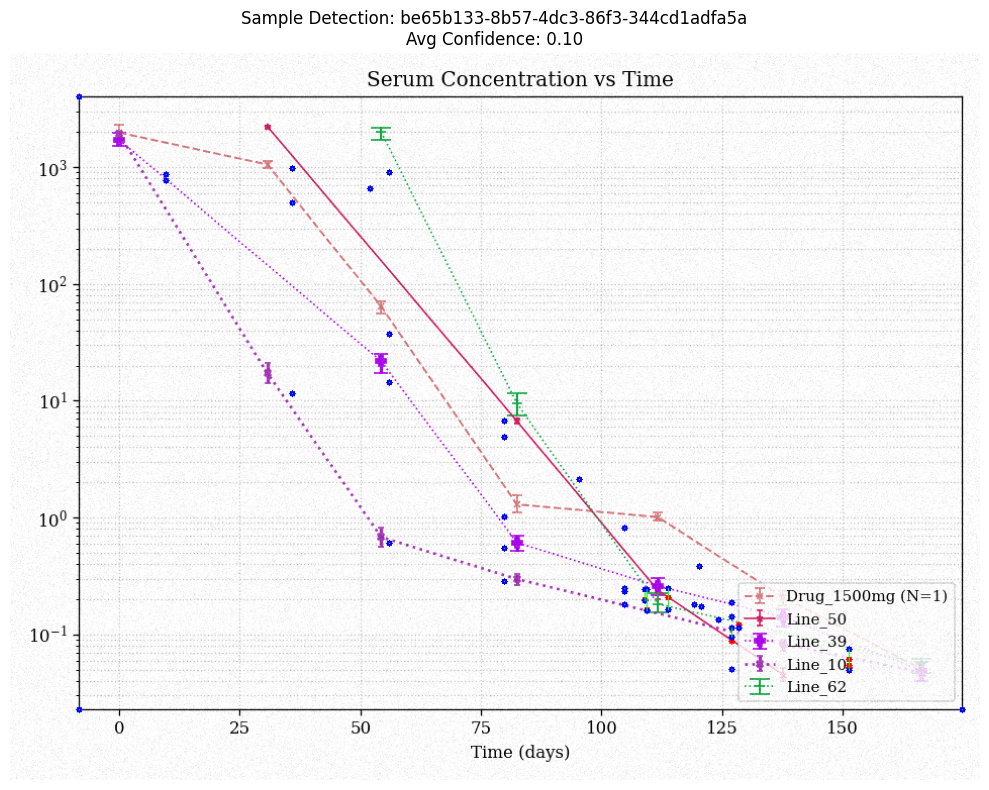


Red circles: Data points
Blue circles: Detected endpoints
Green lines: Detected error bars


In [65]:
from PIL import Image
import matplotlib.pyplot as plt

# Pick a random image from synthetic
img_ids = [os.path.splitext(f)[0] for f in os.listdir(SYNTH_IMG_DIR) if f.endswith(".png")]
sample_id = random.choice(img_ids[:20])

img = cv2.imread(os.path.join(SYNTH_IMG_DIR, sample_id + ".png"))
label = json.load(open(os.path.join(SYNTH_LBL_DIR, sample_id + ".json")))

inp = label_to_xy_only(label)
pred_lines, avg_conf = detect_error_bar_endpoints(img, inp, cfg)

# Draw overlay
over = draw_overlay(img, pred_lines)
over_rgb = cv2.cvtColor(over, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(12, 8))
plt.imshow(over_rgb)
plt.title(f"Sample Detection: {sample_id}\nAvg Confidence: {avg_conf:.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nRed circles: Data points")
print(f"Blue circles: Detected endpoints")
print(f"Green lines: Detected error bars")

In [66]:
def create_input_from_label(label_json: List[Dict], image_filename: str) -> Dict[str, Any]:
    """
    Convert label format to input format (strip GT, keep coordinates only).
    """
    data_points = []
    for line in label_json:
        line_name = line["label"]["lineName"]
        # Filter out anchor points (xmin, ymin, xmax, ymax)
        points = [
            {"x": float(p["x"]), "y": float(p["y"])}
            for p in line["points"]
            if p.get("label", "") == ""  # only actual data points
        ]
        if points:
            data_points.append({"lineName": line_name, "points": points})
    
    return {
        "image_file": image_filename,
        "data_points": data_points
    }


def generate_output_jsons(
    images_dir: str,
    labels_dir: str,
    output_dir: str,
    cfg: DetConfig,
    n_samples: int = None
):
    """
    Generate output JSON files for all images in dataset.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
    if n_samples:
        image_files = image_files[:n_samples]
    
    print(f"Processing {len(image_files)} images...")
    print(f"Output directory: {output_dir}\n")
    
    for img_filename in tqdm(image_files):
        img_id = os.path.splitext(img_filename)[0]
        
        img_path = os.path.join(images_dir, img_filename)
        label_path = os.path.join(labels_dir, f"{img_id}.json")
        output_path = os.path.join(output_dir, f"{img_id}.json")
        
        # Check if label exists
        if not os.path.exists(label_path):
            print(f"Warning: No label for {img_filename}")
            continue
        
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read {img_path}")
            continue
        
        # Load label
        with open(label_path, 'r') as f:
            label = json.load(f)
        
        # Create input format
        input_data = create_input_from_label(label, img_filename)
        
        # Run detection
        error_bars, avg_conf = detect_error_bar_endpoints(
            img, input_data["data_points"], cfg
        )
        
        # Create output
        output_data = {
            "image_file": img_filename,
            "error_bars": error_bars
        }
        
        # Save output JSON
        with open(output_path, 'w') as f:
            json.dump(output_data, f, indent=2, ensure_ascii=False)
    
    print(f"\n✓ Generated {len(image_files)} output JSON files")
    print(f"  Location: {output_dir}")
    return output_dir

In [ ]:
cfg = DetConfig()

# Generate outputs (adjust n_samples as needed)
generate_output_jsons(
    images_dir=SYNTH_IMG_DIR,
    labels_dir=SYNTH_LBL_DIR,
    output_dir=SYNTH_OUTPUT_DIR, 
    cfg=cfg,
    n_samples=None  # None = all images, or  100 
)

Processing 2850 images...
Output directory: outputs_synthetic



100%|██████████| 2850/2850 [12:57<00:00,  3.66it/s]


✓ Generated 2850 output JSON files
  Location: outputs_synthetic


'outputs_synthetic'

In [68]:
# Generate outputs
generate_output_jsons(
    images_dir=REAL_IMG_DIR,
    labels_dir=REAL_LBL_DIR,
    output_dir=REAL_OUTPUT_DIR,
    cfg=cfg,
    n_samples=None  # Process all 150 real images
)

Processing 150 images...
Output directory: outputs_real



100%|██████████| 150/150 [00:59<00:00,  2.51it/s]


✓ Generated 150 output JSON files
  Location: outputs_real


'outputs_real'

In [69]:
!zip -r "outputs_real.zip" "/kaggle/working/outputs_real"

!zip -r "outputs_synthetic.zip" "/kaggle/working/outputs_synthetic"

  adding: kaggle/working/outputs_real/ (stored 0%)
  adding: kaggle/working/outputs_real/71ae9eb6-d9ae-4f1e-b9e9-9c3432815a6a.json (deflated 90%)
  adding: kaggle/working/outputs_real/d4ddb2ba-8de4-444b-a896-8d49d59e1526.json (deflated 82%)
  adding: kaggle/working/outputs_real/cf9ebb32-4f92-4afc-ae31-322eaf5dd404.json (deflated 92%)
  adding: kaggle/working/outputs_real/d2243df5-4cc1-4f0e-b57d-1e76f37e5ece.json (deflated 87%)
  adding: kaggle/working/outputs_real/35acb16b-5455-4903-9603-33856d719fbe.json (deflated 87%)
  adding: kaggle/working/outputs_real/1be94e59-4faf-48a7-89db-b6cacf388ae5.json (deflated 87%)
  adding: kaggle/working/outputs_real/adf0aca6-00fd-4db4-b922-f4b42c2d9b53.json (deflated 87%)
  adding: kaggle/working/outputs_real/4f921224-2545-4369-a8a3-a58dc9c976b0.json (deflated 88%)
  adding: kaggle/working/outputs_real/899d2ded-6fa5-4709-87f6-2b3f8fd99289.json (deflated 88%)
  adding: kaggle/working/outputs_real/cce3c2e0-753e-47a0-b6d8-028f08a19516.json (deflated 88%)